In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os


In [3]:
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
# Set the path to the main folder
dataset_dir = '/content/drive/My Drive/a/'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize image to 224x224
    transforms.RandomH(),    # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(30),        # Randomly rotate the image by up to 30 degrees
    transforms.RandomResizedCrop(224),    # Randomly crop and resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change brightness, contrast, saturation, and hue
    transforms.RandomGrayscale(p=0.1),    # Randomly convert the image to grayscale with a probability of 0.1
    transforms.ToTensor(),                # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image using mean and std of ImageNet
])
# Load dataset
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Get class names
class_names = dataset.classes

# Print class names
print("Class names:", class_names)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Class names: ['abbey', 'airplane_cabin', 'airport_terminal', 'alley', 'amphitheater', 'amusement_arcade', 'amusement_park', 'anechoic_chamber', 'apartment_building', 'aquarium', 'aqueduct', 'arch', 'archive', 'art_gallery', 'art_school', 'art_studio', 'assembly_line', 'attic', 'auditorium', 'auto_factory']


In [5]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 20),
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

model, criterion, optimizer = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 206MB/s]


In [6]:
num_epochs = 20
losses_per_epoch = []
save_dir = "/content/drive/My Drive/ckp_aug"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as batch_progress:
        for inputs, labels in batch_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the progress bar with the current loss
            batch_progress.set_postfix(loss=running_loss/len(train_loader))
    # Calculate the average loss for the current epoch
    epoch_loss = running_loss / len(train_loader)
    losses_per_epoch.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

    save_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss,
    }, save_path)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')


Epoch [1/20]: 100%|██████████| 168/168 [1:21:34<00:00, 29.13s/it, loss=2.05]


Epoch [1/20], Loss: 2.049296064036233
Epoch [1/20], Loss: 2.049296064036233



Epoch [2/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [1/20]:   0%|          | 0/168 [1:21:34<?, ?it/s]


Epoch [2/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.0101]

Epoch [2/20]:   1%|          | 1/168 [00:00<02:37,  1.06it/s, loss=0.0101]

Epoch [2/20]:   1%|          | 1/168 [00:02<02:37,  1.06it/s, loss=0.0194]

Epoch [2/20]:   1%|          | 2/168 [00:02<02:58,  1.07s/it, loss=0.0194]

Epoch [2/20]:   1%|          | 2/168 [00:03<02:58,  1.07s/it, loss=0.0279]

Epoch [2/20]:   2%|▏         | 3/168 [00:03<02:44,  1.01it/s, loss=0.0279]

Epoch [2/20]:   2%|▏         | 3/168 [00:04<02:44,  1.01it/s, loss=0.0377]

Epoch [2/20]:   2%|▏         | 4/168 [00:04<02:58,  1.09s/it, loss=0.0377]

Epoch [2/20]:   2%|▏         | 4/168 [00:04<02:58,  1.09s/it, loss=0.0484]

Epoch [2/20]:   3%|▎         | 5/168 [00:04<02:36,  1.04it/s, loss=0.0484]

Epoch [2/20]:   3%|▎         | 5/168 [00:06<02:36,  1.04it/s, loss=0.0577]

Epoch [2/20]:   4%|▎         | 6/168 [00:06<02:59,  1.11s/

Epoch [2/20], Loss: 1.3661371629152979
Epoch [2/20], Loss: 1.3661371629152979


Epoch [3/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [2/20]:   0%|          | 0/168 [02:53<?, ?it/s]


Epoch [3/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00798]

Epoch [3/20]:   1%|          | 1/168 [00:00<02:35,  1.07it/s, loss=0.00798]

Epoch [3/20]:   1%|          | 1/168 [00:02<02:35,  1.07it/s, loss=0.0161] 

Epoch [3/20]:   1%|          | 2/168 [00:02<02:53,  1.05s/it, loss=0.0161]

Epoch [3/20]:   1%|          | 2/168 [00:03<02:53,  1.05s/it, loss=0.0231]

Epoch [3/20]:   2%|▏         | 3/168 [00:03<02:47,  1.02s/it, loss=0.0231]

Epoch [3/20]:   2%|▏         | 3/168 [00:04<02:47,  1.02s/it, loss=0.0303]

Epoch [3/20]:   2%|▏         | 4/168 [00:04<02:58,  1.09s/it, loss=0.0303]

Epoch [3/20]:   2%|▏         | 4/168 [00:05<02:58,  1.09s/it, loss=0.0396]

Epoch [3/20]:   3%|▎         | 5/168 [00:05<02:54,  1.07s/it, loss=0.0396]

Epoch [3/20]:   3%|▎         | 5/168 [00:06<02:54,  1.07s/it, loss=0.0454]

Epoch [3/20]:   4%|▎         | 6/168 [00:06<02:59,  1.11s/

Epoch [3/20], Loss: 1.1864598425371307
Epoch [3/20], Loss: 1.1864598425371307



Epoch [4/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [3/20]:   0%|          | 0/168 [02:52<?, ?it/s]


Epoch [4/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00586]

Epoch [4/20]:   1%|          | 1/168 [00:01<03:14,  1.16s/it, loss=0.00586]

Epoch [4/20]:   1%|          | 1/168 [00:02<03:14,  1.16s/it, loss=0.0125] 

Epoch [4/20]:   1%|          | 2/168 [00:02<02:49,  1.02s/it, loss=0.0125]

Epoch [4/20]:   1%|          | 2/168 [00:02<02:49,  1.02s/it, loss=0.0178]

Epoch [4/20]:   2%|▏         | 3/168 [00:02<02:36,  1.06it/s, loss=0.0178]

Epoch [4/20]:   2%|▏         | 3/168 [00:03<02:36,  1.06it/s, loss=0.0264]

Epoch [4/20]:   2%|▏         | 4/168 [00:03<02:28,  1.11it/s, loss=0.0264]

Epoch [4/20]:   2%|▏         | 4/168 [00:04<02:28,  1.11it/s, loss=0.0354]

Epoch [4/20]:   3%|▎         | 5/168 [00:04<02:39,  1.02it/s, loss=0.0354]

Epoch [4/20]:   3%|▎         | 5/168 [00:05<02:39,  1.02it/s, loss=0.0433]

Epoch [4/20]:   4%|▎         | 6/168 [00:05<02:27,  1.10i

Epoch [4/20], Loss: 1.1243177638167428
Epoch [4/20], Loss: 1.1243177638167428


Epoch [5/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [4/20]:   0%|          | 0/168 [02:53<?, ?it/s]


Epoch [5/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00684]

Epoch [5/20]:   1%|          | 1/168 [00:00<02:25,  1.15it/s, loss=0.00684]

Epoch [5/20]:   1%|          | 1/168 [00:02<02:25,  1.15it/s, loss=0.0116] 

Epoch [5/20]:   1%|          | 2/168 [00:02<03:08,  1.13s/it, loss=0.0116]

Epoch [5/20]:   1%|          | 2/168 [00:03<03:08,  1.13s/it, loss=0.0189]

Epoch [5/20]:   2%|▏         | 3/168 [00:03<02:48,  1.02s/it, loss=0.0189]

Epoch [5/20]:   2%|▏         | 3/168 [00:03<02:48,  1.02s/it, loss=0.0241]

Epoch [5/20]:   2%|▏         | 4/168 [00:04<02:41,  1.02it/s, loss=0.0241]

Epoch [5/20]:   2%|▏         | 4/168 [00:05<02:41,  1.02it/s, loss=0.0301]

Epoch [5/20]:   3%|▎         | 5/168 [00:05<03:08,  1.16s/it, loss=0.0301]

Epoch [5/20]:   3%|▎         | 5/168 [00:06<03:08,  1.16s/it, loss=0.0376]

Epoch [5/20]:   4%|▎         | 6/168 [00:06<03:08,  1.16s/

Epoch [5/20], Loss: 1.0632206119951748
Epoch [5/20], Loss: 1.0632206119951748



Epoch [6/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [5/20]:   0%|          | 0/168 [02:54<?, ?it/s]


Epoch [6/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00449]

Epoch [6/20]:   1%|          | 1/168 [00:01<02:51,  1.03s/it, loss=0.00449]

Epoch [6/20]:   1%|          | 1/168 [00:02<02:51,  1.03s/it, loss=0.0104] 

Epoch [6/20]:   1%|          | 2/168 [00:02<02:54,  1.05s/it, loss=0.0104]

Epoch [6/20]:   1%|          | 2/168 [00:03<02:54,  1.05s/it, loss=0.0157]

Epoch [6/20]:   2%|▏         | 3/168 [00:03<02:46,  1.01s/it, loss=0.0157]

Epoch [6/20]:   2%|▏         | 3/168 [00:04<02:46,  1.01s/it, loss=0.0202]

Epoch [6/20]:   2%|▏         | 4/168 [00:04<03:13,  1.18s/it, loss=0.0202]

Epoch [6/20]:   2%|▏         | 4/168 [00:05<03:13,  1.18s/it, loss=0.0254]

Epoch [6/20]:   3%|▎         | 5/168 [00:05<02:53,  1.06s/it, loss=0.0254]

Epoch [6/20]:   3%|▎         | 5/168 [00:06<02:53,  1.06s/it, loss=0.0313]

Epoch [6/20]:   4%|▎         | 6/168 [00:06<02:57,  1.09s

Epoch [6/20], Loss: 1.0332571857032322
Epoch [6/20], Loss: 1.0332571857032322


Epoch [7/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [6/20]:   0%|          | 0/168 [02:54<?, ?it/s]


Epoch [7/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00715]

Epoch [7/20]:   1%|          | 1/168 [00:00<02:43,  1.02it/s, loss=0.00715]

Epoch [7/20]:   1%|          | 1/168 [00:01<02:43,  1.02it/s, loss=0.0121] 

Epoch [7/20]:   1%|          | 2/168 [00:01<02:27,  1.13it/s, loss=0.0121]

Epoch [7/20]:   1%|          | 2/168 [00:02<02:27,  1.13it/s, loss=0.0179]

Epoch [7/20]:   2%|▏         | 3/168 [00:02<02:27,  1.12it/s, loss=0.0179]

Epoch [7/20]:   2%|▏         | 3/168 [00:03<02:27,  1.12it/s, loss=0.0266]

Epoch [7/20]:   2%|▏         | 4/168 [00:03<02:29,  1.10it/s, loss=0.0266]

Epoch [7/20]:   2%|▏         | 4/168 [00:04<02:29,  1.10it/s, loss=0.0315]

Epoch [7/20]:   3%|▎         | 5/168 [00:04<02:22,  1.15it/s, loss=0.0315]

Epoch [7/20]:   3%|▎         | 5/168 [00:05<02:22,  1.15it/s, loss=0.0344]

Epoch [7/20]:   4%|▎         | 6/168 [00:05<02:23,  1.13it

Epoch [7/20], Loss: 1.016414848644109
Epoch [7/20], Loss: 1.016414848644109



Epoch [8/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [7/20]:   0%|          | 0/168 [02:53<?, ?it/s]


Epoch [8/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00826]

Epoch [8/20]:   1%|          | 1/168 [00:00<02:21,  1.18it/s, loss=0.00826]

Epoch [8/20]:   1%|          | 1/168 [00:01<02:21,  1.18it/s, loss=0.014]  

Epoch [8/20]:   1%|          | 2/168 [00:01<02:33,  1.08it/s, loss=0.014]

Epoch [8/20]:   1%|          | 2/168 [00:02<02:33,  1.08it/s, loss=0.018]

Epoch [8/20]:   2%|▏         | 3/168 [00:02<02:37,  1.05it/s, loss=0.018]

Epoch [8/20]:   2%|▏         | 3/168 [00:04<02:37,  1.05it/s, loss=0.0246]

Epoch [8/20]:   2%|▏         | 4/168 [00:04<03:21,  1.23s/it, loss=0.0246]

Epoch [8/20]:   2%|▏         | 4/168 [00:05<03:21,  1.23s/it, loss=0.0325]

Epoch [8/20]:   3%|▎         | 5/168 [00:05<03:08,  1.16s/it, loss=0.0325]

Epoch [8/20]:   3%|▎         | 5/168 [00:06<03:08,  1.16s/it, loss=0.0387]

Epoch [8/20]:   4%|▎         | 6/168 [00:06<03:10,  1.18s/it

Epoch [8/20], Loss: 1.0128084296981494
Epoch [8/20], Loss: 1.0128084296981494


Epoch [9/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [8/20]:   0%|          | 0/168 [02:53<?, ?it/s]


Epoch [9/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00679]

Epoch [9/20]:   1%|          | 1/168 [00:01<04:57,  1.78s/it, loss=0.00679]

Epoch [9/20]:   1%|          | 1/168 [00:02<04:57,  1.78s/it, loss=0.0132] 

Epoch [9/20]:   1%|          | 2/168 [00:02<03:52,  1.40s/it, loss=0.0132]

Epoch [9/20]:   1%|          | 2/168 [00:03<03:52,  1.40s/it, loss=0.0179]

Epoch [9/20]:   2%|▏         | 3/168 [00:03<03:06,  1.13s/it, loss=0.0179]

Epoch [9/20]:   2%|▏         | 3/168 [00:04<03:06,  1.13s/it, loss=0.0222]

Epoch [9/20]:   2%|▏         | 4/168 [00:04<02:57,  1.08s/it, loss=0.0222]

Epoch [9/20]:   2%|▏         | 4/168 [00:05<02:57,  1.08s/it, loss=0.0278]

Epoch [9/20]:   3%|▎         | 5/168 [00:05<02:55,  1.08s/it, loss=0.0278]

Epoch [9/20]:   3%|▎         | 5/168 [00:06<02:55,  1.08s/it, loss=0.0325]

Epoch [9/20]:   4%|▎         | 6/168 [00:06<02:53,  1.07s/

Epoch [9/20], Loss: 0.9872605782889184
Epoch [9/20], Loss: 0.9872605782889184



Epoch [10/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [9/20]:   0%|          | 0/168 [02:53<?, ?it/s]


Epoch [10/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00487]

Epoch [10/20]:   1%|          | 1/168 [00:00<02:22,  1.18it/s, loss=0.00487]

Epoch [10/20]:   1%|          | 1/168 [00:01<02:22,  1.18it/s, loss=0.0114] 

Epoch [10/20]:   1%|          | 2/168 [00:01<02:30,  1.10it/s, loss=0.0114]

Epoch [10/20]:   1%|          | 2/168 [00:03<02:30,  1.10it/s, loss=0.0164]

Epoch [10/20]:   2%|▏         | 3/168 [00:03<02:57,  1.08s/it, loss=0.0164]

Epoch [10/20]:   2%|▏         | 3/168 [00:04<02:57,  1.08s/it, loss=0.0224]

Epoch [10/20]:   2%|▏         | 4/168 [00:04<02:58,  1.09s/it, loss=0.0224]

Epoch [10/20]:   2%|▏         | 4/168 [00:05<02:58,  1.09s/it, loss=0.0268]

Epoch [10/20]:   3%|▎         | 5/168 [00:05<03:13,  1.19s/it, loss=0.0268]

Epoch [10/20]:   3%|▎         | 5/168 [00:06<03:13,  1.19s/it, loss=0.031] 

Epoch [10/20]:   4%|▎         | 6/168 [00:06<

Epoch [10/20], Loss: 0.9402224412631421
Epoch [10/20], Loss: 0.9402224412631421


Epoch [11/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [10/20]:   0%|          | 0/168 [02:53<?, ?it/s]


Epoch [11/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00537]

Epoch [11/20]:   1%|          | 1/168 [00:00<02:46,  1.01it/s, loss=0.00537]

Epoch [11/20]:   1%|          | 1/168 [00:01<02:46,  1.01it/s, loss=0.0123] 

Epoch [11/20]:   1%|          | 2/168 [00:01<02:29,  1.11it/s, loss=0.0123]

Epoch [11/20]:   1%|          | 2/168 [00:02<02:29,  1.11it/s, loss=0.0164]

Epoch [11/20]:   2%|▏         | 3/168 [00:02<02:43,  1.01it/s, loss=0.0164]

Epoch [11/20]:   2%|▏         | 3/168 [00:04<02:43,  1.01it/s, loss=0.0229]

Epoch [11/20]:   2%|▏         | 4/168 [00:04<02:48,  1.03s/it, loss=0.0229]

Epoch [11/20]:   2%|▏         | 4/168 [00:05<02:48,  1.03s/it, loss=0.0283]

Epoch [11/20]:   3%|▎         | 5/168 [00:05<02:54,  1.07s/it, loss=0.0283]

Epoch [11/20]:   3%|▎         | 5/168 [00:05<02:54,  1.07s/it, loss=0.0337]

Epoch [11/20]:   4%|▎         | 6/168 [00:05<

Epoch [11/20], Loss: 0.9465082252309436
Epoch [11/20], Loss: 0.9465082252309436



Epoch [12/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [11/20]:   0%|          | 0/168 [02:54<?, ?it/s]


Epoch [12/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00446]

Epoch [12/20]:   1%|          | 1/168 [00:00<02:13,  1.25it/s, loss=0.00446]

Epoch [12/20]:   1%|          | 1/168 [00:01<02:13,  1.25it/s, loss=0.00853]

Epoch [12/20]:   1%|          | 2/168 [00:01<02:35,  1.07it/s, loss=0.00853]

Epoch [12/20]:   1%|          | 2/168 [00:02<02:35,  1.07it/s, loss=0.0142] 

Epoch [12/20]:   2%|▏         | 3/168 [00:02<02:37,  1.04it/s, loss=0.0142]

Epoch [12/20]:   2%|▏         | 3/168 [00:03<02:37,  1.04it/s, loss=0.0182]

Epoch [12/20]:   2%|▏         | 4/168 [00:03<02:36,  1.05it/s, loss=0.0182]

Epoch [12/20]:   2%|▏         | 4/168 [00:04<02:36,  1.05it/s, loss=0.023] 

Epoch [12/20]:   3%|▎         | 5/168 [00:04<02:45,  1.01s/it, loss=0.023]

Epoch [12/20]:   3%|▎         | 5/168 [00:05<02:45,  1.01s/it, loss=0.0273]

Epoch [12/20]:   4%|▎         | 6/168 [00:0

Epoch [12/20], Loss: 0.9286559843236492
Epoch [12/20], Loss: 0.9286559843236492


Epoch [13/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [12/20]:   0%|          | 0/168 [02:54<?, ?it/s]


Epoch [13/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.0068]

Epoch [13/20]:   1%|          | 1/168 [00:01<02:48,  1.01s/it, loss=0.0068]

Epoch [13/20]:   1%|          | 1/168 [00:01<02:48,  1.01s/it, loss=0.0131]

Epoch [13/20]:   1%|          | 2/168 [00:01<02:26,  1.13it/s, loss=0.0131]

Epoch [13/20]:   1%|          | 2/168 [00:02<02:26,  1.13it/s, loss=0.0164]

Epoch [13/20]:   2%|▏         | 3/168 [00:02<02:35,  1.06it/s, loss=0.0164]

Epoch [13/20]:   2%|▏         | 3/168 [00:03<02:35,  1.06it/s, loss=0.0228]

Epoch [13/20]:   2%|▏         | 4/168 [00:03<02:34,  1.06it/s, loss=0.0228]

Epoch [13/20]:   2%|▏         | 4/168 [00:04<02:34,  1.06it/s, loss=0.0283]

Epoch [13/20]:   3%|▎         | 5/168 [00:04<02:31,  1.08it/s, loss=0.0283]

Epoch [13/20]:   3%|▎         | 5/168 [00:05<02:31,  1.08it/s, loss=0.0334]

Epoch [13/20]:   4%|▎         | 6/168 [00:05<02:

Epoch [13/20], Loss: 0.9079858715690318
Epoch [13/20], Loss: 0.9079858715690318



Epoch [14/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [13/20]:   0%|          | 0/168 [02:54<?, ?it/s]


Epoch [14/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00384]

Epoch [14/20]:   1%|          | 1/168 [00:01<03:25,  1.23s/it, loss=0.00384]

Epoch [14/20]:   1%|          | 1/168 [00:02<03:25,  1.23s/it, loss=0.00927]

Epoch [14/20]:   1%|          | 2/168 [00:02<03:04,  1.11s/it, loss=0.00927]

Epoch [14/20]:   1%|          | 2/168 [00:03<03:04,  1.11s/it, loss=0.0153] 

Epoch [14/20]:   2%|▏         | 3/168 [00:03<02:38,  1.04it/s, loss=0.0153]

Epoch [14/20]:   2%|▏         | 3/168 [00:03<02:38,  1.04it/s, loss=0.0212]

Epoch [14/20]:   2%|▏         | 4/168 [00:03<02:24,  1.13it/s, loss=0.0212]

Epoch [14/20]:   2%|▏         | 4/168 [00:05<02:24,  1.13it/s, loss=0.0285]

Epoch [14/20]:   3%|▎         | 5/168 [00:05<02:43,  1.00s/it, loss=0.0285]

Epoch [14/20]:   3%|▎         | 5/168 [00:05<02:43,  1.00s/it, loss=0.0358]

Epoch [14/20]:   4%|▎         | 6/168 [00:

Epoch [14/20], Loss: 0.91877054653707
Epoch [14/20], Loss: 0.91877054653707


Epoch [15/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [14/20]:   0%|          | 0/168 [02:54<?, ?it/s]


Epoch [15/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00597]

Epoch [15/20]:   1%|          | 1/168 [00:00<02:14,  1.24it/s, loss=0.00597]

Epoch [15/20]:   1%|          | 1/168 [00:02<02:14,  1.24it/s, loss=0.0134] 

Epoch [15/20]:   1%|          | 2/168 [00:02<03:03,  1.11s/it, loss=0.0134]

Epoch [15/20]:   1%|          | 2/168 [00:03<03:03,  1.11s/it, loss=0.0191]

Epoch [15/20]:   2%|▏         | 3/168 [00:03<02:45,  1.00s/it, loss=0.0191]

Epoch [15/20]:   2%|▏         | 3/168 [00:04<02:45,  1.00s/it, loss=0.0258]

Epoch [15/20]:   2%|▏         | 4/168 [00:04<03:00,  1.10s/it, loss=0.0258]

Epoch [15/20]:   2%|▏         | 4/168 [00:05<03:00,  1.10s/it, loss=0.0326]

Epoch [15/20]:   3%|▎         | 5/168 [00:05<03:09,  1.16s/it, loss=0.0326]

Epoch [15/20]:   3%|▎         | 5/168 [00:06<03:09,  1.16s/it, loss=0.0383]

Epoch [15/20]:   4%|▎         | 6/168 [00:06<

Epoch [15/20], Loss: 0.9054629015071052
Epoch [15/20], Loss: 0.9054629015071052



Epoch [16/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [15/20]:   0%|          | 0/168 [02:54<?, ?it/s]


Epoch [16/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00539]

Epoch [16/20]:   1%|          | 1/168 [00:01<03:05,  1.11s/it, loss=0.00539]

Epoch [16/20]:   1%|          | 1/168 [00:02<03:05,  1.11s/it, loss=0.0122] 

Epoch [16/20]:   1%|          | 2/168 [00:02<03:04,  1.11s/it, loss=0.0122]

Epoch [16/20]:   1%|          | 2/168 [00:03<03:04,  1.11s/it, loss=0.0169]

Epoch [16/20]:   2%|▏         | 3/168 [00:03<02:51,  1.04s/it, loss=0.0169]

Epoch [16/20]:   2%|▏         | 3/168 [00:04<02:51,  1.04s/it, loss=0.0202]

Epoch [16/20]:   2%|▏         | 4/168 [00:04<02:43,  1.00it/s, loss=0.0202]

Epoch [16/20]:   2%|▏         | 4/168 [00:05<02:43,  1.00it/s, loss=0.0245]

Epoch [16/20]:   3%|▎         | 5/168 [00:05<03:06,  1.15s/it, loss=0.0245]

Epoch [16/20]:   3%|▎         | 5/168 [00:06<03:06,  1.15s/it, loss=0.0293]

Epoch [16/20]:   4%|▎         | 6/168 [00:06

Epoch [16/20], Loss: 0.8979851688657489
Epoch [16/20], Loss: 0.8979851688657489


Epoch [17/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [16/20]:   0%|          | 0/168 [02:54<?, ?it/s]


Epoch [17/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.00849]

Epoch [17/20]:   1%|          | 1/168 [00:01<03:18,  1.19s/it, loss=0.00849]

Epoch [17/20]:   1%|          | 1/168 [00:02<03:18,  1.19s/it, loss=0.0127] 

Epoch [17/20]:   1%|          | 2/168 [00:02<03:31,  1.27s/it, loss=0.0127]

Epoch [17/20]:   1%|          | 2/168 [00:03<03:31,  1.27s/it, loss=0.0196]

Epoch [17/20]:   2%|▏         | 3/168 [00:03<03:15,  1.19s/it, loss=0.0196]

Epoch [17/20]:   2%|▏         | 3/168 [00:04<03:15,  1.19s/it, loss=0.0255]

Epoch [17/20]:   2%|▏         | 4/168 [00:04<03:07,  1.14s/it, loss=0.0255]

Epoch [17/20]:   2%|▏         | 4/168 [00:05<03:07,  1.14s/it, loss=0.0318]

Epoch [17/20]:   3%|▎         | 5/168 [00:05<02:56,  1.08s/it, loss=0.0318]

Epoch [17/20]:   3%|▎         | 5/168 [00:06<02:56,  1.08s/it, loss=0.0351]

Epoch [17/20]:   4%|▎         | 6/168 [00:06<

Epoch [17/20], Loss: 0.9024018375646501
Epoch [17/20], Loss: 0.9024018375646501



Epoch [18/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [17/20]:   0%|          | 0/168 [02:54<?, ?it/s]


Epoch [18/20]:   0%|          | 0/168 [00:00<?, ?it/s, loss=0.00584]

Epoch [18/20]:   1%|          | 1/168 [00:00<02:45,  1.01it/s, loss=0.00584]

Epoch [18/20]:   1%|          | 1/168 [00:02<02:45,  1.01it/s, loss=0.0119] 

Epoch [18/20]:   1%|          | 2/168 [00:02<02:53,  1.05s/it, loss=0.0119]

Epoch [18/20]:   1%|          | 2/168 [00:02<02:53,  1.05s/it, loss=0.0193]

Epoch [18/20]:   2%|▏         | 3/168 [00:02<02:26,  1.13it/s, loss=0.0193]

Epoch [18/20]:   2%|▏         | 3/168 [00:03<02:26,  1.13it/s, loss=0.0216]

Epoch [18/20]:   2%|▏         | 4/168 [00:03<02:47,  1.02s/it, loss=0.0216]

Epoch [18/20]:   2%|▏         | 4/168 [00:04<02:47,  1.02s/it, loss=0.0285]

Epoch [18/20]:   3%|▎         | 5/168 [00:04<02:29,  1.09it/s, loss=0.0285]

Epoch [18/20]:   3%|▎         | 5/168 [00:05<02:29,  1.09it/s, loss=0.0335]

Epoch [18/20]:   4%|▎         | 6/168 [00:05

Epoch [18/20], Loss: 0.8980082576828343
Epoch [18/20], Loss: 0.8980082576828343


Epoch [19/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [18/20]:   0%|          | 0/168 [02:54<?, ?it/s]


Epoch [19/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.0056]

Epoch [19/20]:   1%|          | 1/168 [00:01<02:53,  1.04s/it, loss=0.0056]

Epoch [19/20]:   1%|          | 1/168 [00:02<02:53,  1.04s/it, loss=0.0106]

Epoch [19/20]:   1%|          | 2/168 [00:02<03:03,  1.10s/it, loss=0.0106]

Epoch [19/20]:   1%|          | 2/168 [00:02<03:03,  1.10s/it, loss=0.0139]

Epoch [19/20]:   2%|▏         | 3/168 [00:02<02:29,  1.10it/s, loss=0.0139]

Epoch [19/20]:   2%|▏         | 3/168 [00:03<02:29,  1.10it/s, loss=0.0192]

Epoch [19/20]:   2%|▏         | 4/168 [00:03<02:36,  1.05it/s, loss=0.0192]

Epoch [19/20]:   2%|▏         | 4/168 [00:04<02:36,  1.05it/s, loss=0.0229]

Epoch [19/20]:   3%|▎         | 5/168 [00:04<02:30,  1.08it/s, loss=0.0229]

Epoch [19/20]:   3%|▎         | 5/168 [00:05<02:30,  1.08it/s, loss=0.029] 

Epoch [19/20]:   4%|▎         | 6/168 [00:05<02:

Epoch [19/20], Loss: 0.8767500468308017
Epoch [19/20], Loss: 0.8767500468308017



Epoch [20/20]:   0%|          | 0/168 [00:00<?, ?it/s]

Epoch [19/20]:   0%|          | 0/168 [02:53<?, ?it/s]


Epoch [20/20]:   0%|          | 0/168 [00:01<?, ?it/s, loss=0.0054]

Epoch [20/20]:   1%|          | 1/168 [00:01<03:06,  1.12s/it, loss=0.0054]

Epoch [20/20]:   1%|          | 1/168 [00:02<03:06,  1.12s/it, loss=0.0159]

Epoch [20/20]:   1%|          | 2/168 [00:02<03:11,  1.16s/it, loss=0.0159]

Epoch [20/20]:   1%|          | 2/168 [00:03<03:11,  1.16s/it, loss=0.0213]

Epoch [20/20]:   2%|▏         | 3/168 [00:03<03:17,  1.19s/it, loss=0.0213]

Epoch [20/20]:   2%|▏         | 3/168 [00:04<03:17,  1.19s/it, loss=0.0265]

Epoch [20/20]:   2%|▏         | 4/168 [00:04<03:03,  1.12s/it, loss=0.0265]

Epoch [20/20]:   2%|▏         | 4/168 [00:05<03:03,  1.12s/it, loss=0.0306]

Epoch [20/20]:   3%|▎         | 5/168 [00:05<02:51,  1.05s/it, loss=0.0306]

Epoch [20/20]:   3%|▎         | 5/168 [00:06<02:51,  1.05s/it, loss=0.0351]

Epoch [20/20]:   4%|▎         | 6/168 [00:06<02

Epoch [20/20], Loss: 0.8648464149307638
Epoch [20/20], Loss: 0.8648464149307638


# Evaluation

In [7]:
print("\nLoss for each epoch:")
for epoch, loss in enumerate(losses_per_epoch, 1):
    print(f"Epoch {epoch}: {loss}")


Loss for each epoch:
Epoch 1: 2.049296064036233
Epoch 2: 1.3661371629152979
Epoch 3: 1.1864598425371307
Epoch 4: 1.1243177638167428
Epoch 5: 1.0632206119951748
Epoch 6: 1.0332571857032322
Epoch 7: 1.016414848644109
Epoch 8: 1.0128084296981494
Epoch 9: 0.9872605782889184
Epoch 10: 0.9402224412631421
Epoch 11: 0.9465082252309436
Epoch 12: 0.9286559843236492
Epoch 13: 0.9079858715690318
Epoch 14: 0.91877054653707
Epoch 15: 0.9054629015071052
Epoch 16: 0.8979851688657489
Epoch 17: 0.9024018375646501
Epoch 18: 0.8980082576828343
Epoch 19: 0.8767500468308017
Epoch 20: 0.8648464149307638


<ipython-input-12-59eca4e781c0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Evaluating: 100%|██████████| 42/42 [00:41<00:00,  1

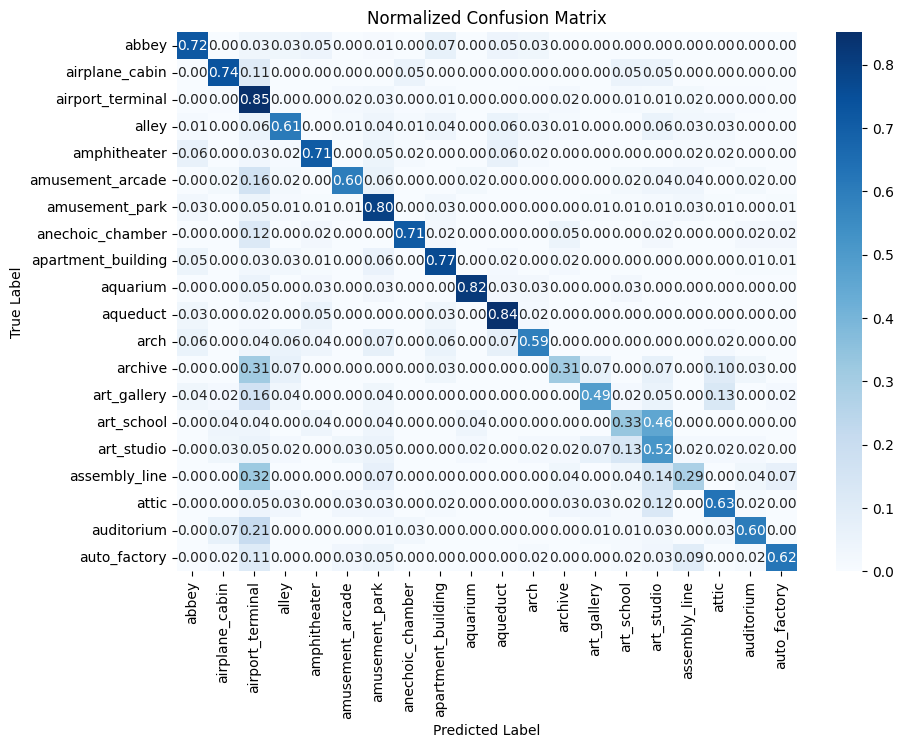

In [12]:
checkpoint_path = '/content/drive/My Drive/ckp_aug/model_epoch_20.pth'

# Load the saved checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        # Move inputs and labels to device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

        # Append true and predicted labels to respective lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix to range [0, 1]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses_per_epoch) + 1), losses_per_epoch, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, len(losses_per_epoch) + 1))  # Set x-axis ticks for each epoch
plt.show()

In [10]:
# Calculate accuracy for the last epoch
correct_predictions = 0
total_predictions = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in tqdm(train_loader, desc="Evaluating last epoch"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

        # Count correct predictions
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate accuracy
last_epoch_accuracy = correct_predictions / total_predictions * 100  # Convert to percentage

# Print accuracy for the last epoch
print(f"Accuracy for the last epoch [{epoch}]: {last_epoch_accuracy:.2f}%")

Evaluating last epoch: 100%|██████████| 168/168 [02:51<00:00,  1.02s/it]

Accuracy for the last epoch [20]: 74.27%


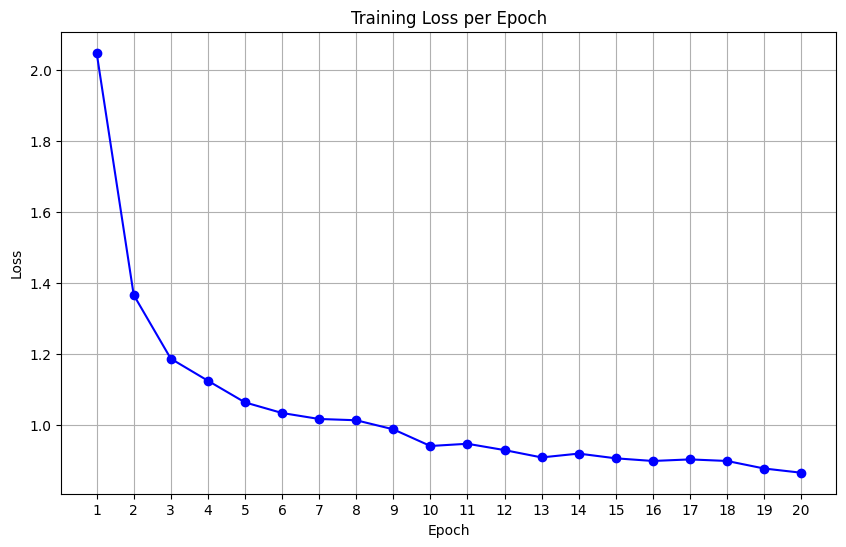

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses_per_epoch) + 1), losses_per_epoch, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(range(1, len(losses_per_epoch) + 1))  # Set x-axis ticks for each epoch
plt.show()